<a href="https://colab.research.google.com/github/AUT-Student/NN-HW2/blob/main/NN_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Datasets

In [ ]:
class Dataset():
  def __init__(self, dataset_type):
    if dataset_type == "LinearSeprable":
      self._create_ls_dataset()
    elif dataset_type == "XOR":
      self._create_xor_dataset()

    self._shuffle_and_split()

  def _create_ls_dataset(self):
    cov = [[1, 0], [0, 1]]

    mean_0 = [0,0]
    mean_1 = [10,10]

    number_data_per_class = 5000    

    data_0 = pd.DataFrame(np.random.multivariate_normal(mean_0, cov, number_data_per_class), columns=["X1", "X2"])
    data_0["Y"] = [-1] * number_data_per_class 

    data_1 = pd.DataFrame(np.random.multivariate_normal(mean_1, cov, number_data_per_class), columns=["X1", "X2"])
    data_1["Y"] = [+1] * number_data_per_class

    self.data = pd.concat([data_0, data_1], ignore_index= True)

  def _create_xor_dataset(self):
    cov = [[1, 0], [0, 1]]

    mean_00 = [0, 0]
    mean_01 = [0, 10] 
    mean_10 = [10, 0] 
    mean_11 = [10, 10] 

    number_data_per_part = 2500

    cov = [[1, 0], [0, 1]]

    mean_00 = [0, 0]
    mean_01 = [0, 10] 
    mean_10 = [10, 0] 
    mean_11 = [10, 10] 

    number_data_per_part = 2500

    data_00 = pd.DataFrame(np.random.multivariate_normal(mean_00, cov, number_data_per_part), columns=["X1", "X2"])
    data_00["Y"] = [-1] * number_data_per_part 

    data_11 = pd.DataFrame(np.random.multivariate_normal(mean_11, cov, number_data_per_part), columns=["X1", "X2"])
    data_11["Y"] = [-1] * number_data_per_part 

    data_01 = pd.DataFrame(np.random.multivariate_normal(mean_01, cov, number_data_per_part), columns=["X1", "X2"])
    data_01["Y"] = [+1] * number_data_per_part 

    data_10 = pd.DataFrame(np.random.multivariate_normal(mean_10, cov, number_data_per_part), columns=["X1", "X2"])
    data_10["Y"] = [+1] * number_data_per_part 

    self.data = pd.concat([data_00, data_01, data_10, data_11], ignore_index= True)


  def _shuffle_and_split(self):
    self.data = self.data.sample(frac=1).reset_index()

    # 70% train, 10% validation, 20% test
    self.train_data = self.data[:7000]
    self.validation_data = self.data[7000:8000]
    self.test_data = self.data[8000:]

  def plot_dataset(self):
    plt.scatter(self.data[self.data["Y"]==-1]["X1"], self.data[self.data["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(self.data[self.data["Y"]==+1]["X1"], self.data[self.data["Y"]==+1]["X2"], label="Class +", c="green")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Dataset Overview")
    plt.show()

  def X_train(self):
    return self.train_data[["X1", "X2"]].values

  def Y_train(self):
    return self.train_dataset["Y"].values

  def X_validation(self):
    return self.validation_data[["X1", "X2"]].values

  def Y_validation(self):
    return self.validation_data["Y"].values

  def X_test(self):
    return self.test_data[["X1", "X2"]].values

  def Y_test(self):
    return self.test_data["Y"].values

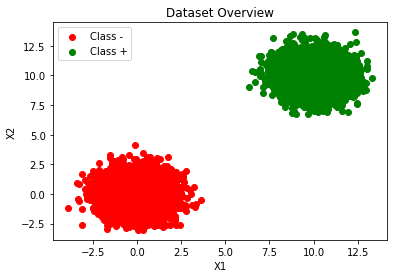

In [ ]:
ls_dataset = Dataset("LinearSeprable")
ls_dataset.plot_dataset()

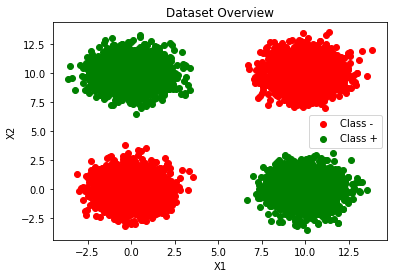

In [ ]:
xor_dataset = Dataset("XOR")
xor_dataset.plot_dataset()

# Activation Functions

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
class ActivationFunctions():

  @staticmethod
  def sigmoid(x):
    return 1 / (1 + math.exp(-x))

  @staticmethod
  def bipolar_sigmoid(x):
    return (1 - math.exp(-x)) / (1 + math.exp(-x))

  @staticmethod
  def identity(x):
    return x

# Perceptron

In [ ]:
class Perceptron():
  def __init__(self, alpha, activation_function, degree=1):
    self.alpha = alpha
    self.activation_function = activation_function
    self.error_values = []
    self.degree = degree

    if self.degree == 1:
      self.w = np.zeros([3])
    elif self.degree == 2:
      self.w = np.zeros([5])
    
  def complete_X(self, X):
    if self.degree == 1:
      return np.concatenate(([1], X))
    elif self.degree == 2:
      return np.array([1, X[0], X[1], X[0]**2, X[1]**2])

  def predict(self, X):
    I = self.w @ self.complete_X(X)
    y = self.activation_function(I)
    
    if y >= 0:
      return +1
    else:
      return -1

  def error(self, X, t):
    sum = 0
    for i in range(len(t)):
      sum += np.abs(self.predict(X[i]) - t[i])
    return sum/(2*len(t))

  def train_sample(self, X, t):
    y = self.predict(X)
    self.w = self.w + self.alpha * (t-y) * self.complete_X(X)

  def train(self, X_train, y_train, X_validation, y_validation, epochs):
    for epoch in range(epochs):
      for i in range(len(X_train)):
        self.train_sample(X_train[i], y_train[i])

        if (i+1)%1000 == 0:
          self.error_values.append(
              {"i": epoch*len(X_train) + i,
               "train": self.error(X_train, y_train),
               "validation": self.error(X_validation, y_validation)
               })
    

  def show_error_values(self):
    i_list = []
    train_error_list = []
    validation_error_list = []

    for item in self.error_values:
      i_list.append(item["i"])
      train_error_list.append(item["train"])
      validation_error_list.append(item["validation"])
    
    plt.scatter(i_list, train_error_list, c="blue", label="Train Error", alpha=0.5)
    plt.plot(i_list, train_error_list, c="blue", alpha=0.5)
    plt.scatter(i_list, validation_error_list, c="red", label="Validation Error", alpha=0.5)
    plt.plot(i_list, validation_error_list, c="red", alpha=0.5)

    plt.legend()
    plt.xlabel("Number Trained Data")
    plt.ylabel("Error")
    plt.title("Error Changes in Training of the Perceptron")
    plt.show()



  def show_decision_boundry(self, dataset):
    plt.scatter(dataset[dataset["Y"]==-1]["X1"], dataset[dataset["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(dataset[dataset["Y"]==+1]["X1"], dataset[dataset["Y"]==+1]["X2"], label="Class +", c="green")

    x = np.linspace(-4, 14, 1000)

    if self.degree == 1:
      plt.plot(x, (-self.w[1]/self.w[2]*x)-self.w[0]/self.w[2], label="Decision Boundry", c="blue")

    elif self.degree == 2:
      w0, w1, w2, w3, w4 = self.w
      plt.plot(x, -w2/w4 + np.sqrt(-w0/w4-w1/w4*x-w3/w4*x**2-(w2/w4)**2) , label="Decision Boundry", c="blue")
      plt.plot(x, -w2/w4 - np.sqrt(-w0/w4-w1/w4*x-w3/w4*x**2-(w2/w4)**2), c="blue")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Perceptron Decision Boundary")
    plt.show()      

In [ ]:
perceptron = Perceptron(
                          alpha=0.001, degree = 2,
                          activation_function=ActivationFunctions.bipolar_sigmoid,
                        )

In [ ]:
perceptron.train(
    X_train = train_dataset[["X1", "X2"]].values,
    y_train = train_dataset["Y"].values,
    X_validation = validation_dataset[["X1", "X2"]].values,
    y_validation = validation_dataset["Y"].values,
    epochs = 5
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in sqrt


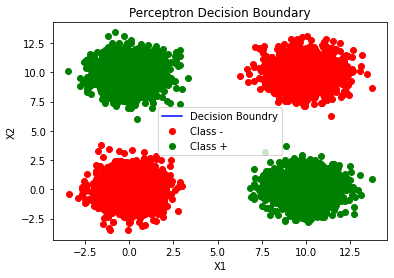

In [ ]:
perceptron.show_decision_boundry(train_dataset)

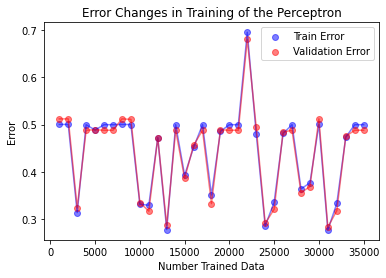

In [ ]:
perceptron.show_error_values()

# Adaline

In [ ]:
class Adaline():
  def __init__(self, w, alpha, activation_function):
    self.w = w
    self.alpha = alpha
    self.activation_function = activation_function
  
  def linear_output(self, X):
    I = self.w @ np.concatenate(([1], X))
    y = self.activation_function(I)
    return y

  def bipolar_output(self, X):
    return np.sign(self.linear_output(X))

  def train_sample(self, X, t):
    y = self.linear_output(X)
    self.w = self.w + self.alpha * (t-y) * np.concatenate(([1], X))

  def train(self, dataset):
    for i, data in dataset.iterrows():
      X = data[["X1", "X2"]].values
      t = data["Y"]

      self.train_sample(X,t)

  def show_decision_boundry(self, dataset):
    plt.scatter(dataset[dataset["Y"]==-1]["X1"], dataset[dataset["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(dataset[dataset["Y"]==+1]["X1"], dataset[dataset["Y"]==+1]["X2"], label="Class +", c="green")

    x = np.linspace(-4, 12, 1000)
    plt.plot(x, (-self.w[1]/self.w[2]*x)-self.w[0]/self.w[2], label="Decision Boundry", c="blue")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Adaline Decision Boundary")
    plt.show()    

In [ ]:
adaline = Adaline(w=np.zeros([3]), alpha=.01, activation_function=ActivationFunctions.identity)

In [ ]:
adaline.train(train_dataset)

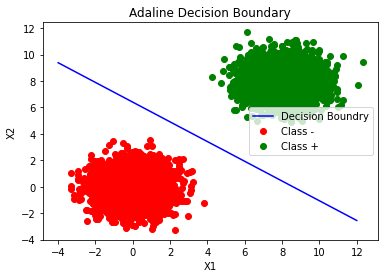

In [ ]:
adaline.show_decision_boundry(train_dataset)

# Perceptron2D

In [ ]:
class Perceptron2D():
  def __init__(self, w, alpha, activation_function):
    self.w = w
    self.alpha = alpha
    self.activation_function = activation_function

  def predict(self, X):
    I = self.w @ np.array([1, X[0], X[1], X[0]**2, X[1]**2]) 
    y = self.activation_function(I)
    return y

  def train_sample(self, X, t):
    y = self.predict(X)
    self.w = self.w + self.alpha * (t-y) * np.array([1, X[0], X[1], X[0]**2, X[1]**2])
  
  def train(self, dataset, epochs):
    for epoch in range(epochs):
      for i, data in dataset.iterrows():
        X = data[["X1", "X2"]].values
        t = data["Y"]
        self.train_sample(X,t)
      self.show_decision_boundry(dataset)

  def show_decision_boundry(self, dataset):
    plt.scatter(dataset[dataset["Y"]==-1]["X1"], dataset[dataset["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(dataset[dataset["Y"]==+1]["X1"], dataset[dataset["Y"]==+1]["X2"], label="Class +", c="green")

    x = np.linspace(-4, 14, 1000)

    w0, w1, w2, w3, w4 = self.w

    self.w[0] + self.w[1]*x + self.w[2] 

    plt.plot(x, -w2/w4 + np.sqrt(-w0/w4-w1/w4*x-w3/w4*x**2-(w2/w4)**2) , label="Decision Boundry", c="blue")
    plt.plot(x, -w2/w4 - np.sqrt(-w0/w4-w1/w4*x-w3/w4*x**2-(w2/w4)**2), c="blue")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Perceptron 2D Decision Boundary")
    plt.show()  

In [ ]:
perceptron2d = Perceptron2D(w=np.zeros([5]), alpha=0.001, activation_function=ActivationFunctions.bipolar_sigmoid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


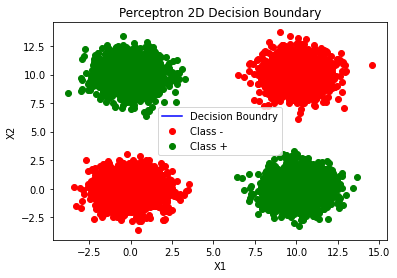

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


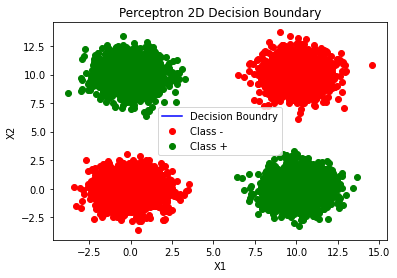

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


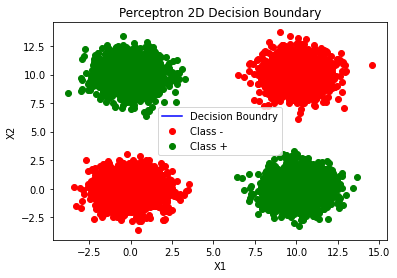

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


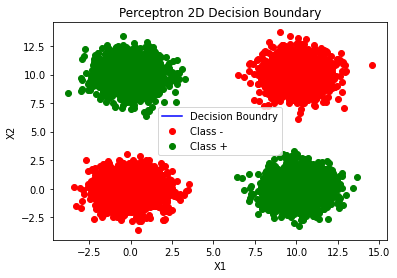

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


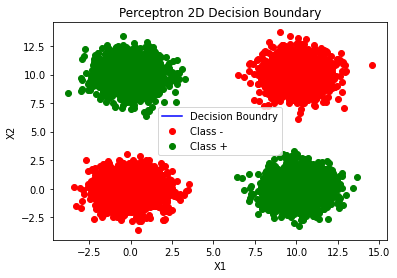

In [ ]:
perceptron2d.train(dataset=train_dataset, epochs=5)

# Adaline2D

In [ ]:
class Adaline2D():
  def __init__(self, w, alpha, activation_function):
    self.w = w
    self.alpha = alpha
    self.activation_function = activation_function
  
  def linear_output(self, X):
    I = self.w @ np.array([1, X[0], X[1], X[0]**2, X[1]**2], X[0]*X[1])
    y = self.activation_function(I)
    return y

  def bipolar_output(self, X):
    return np.sign(self.linear_output(X))

  def train_sample(self, X, t):
    y = self.linear_output(X)
    self.w = self.w + self.alpha * (t-y) * np.array([1, X[0], X[1], X[0]**2, X[1]**2], X[0]*X[1])

  def train(self, dataset):
    for i, data in dataset.iterrows():
      X = data[["X1", "X2"]].values
      t = data["Y"]

      self.train_sample(X,t)

  def show_decision_boundry(self, dataset):
    plt.scatter(dataset[dataset["Y"]==-1]["X1"], dataset[dataset["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(dataset[dataset["Y"]==+1]["X1"], dataset[dataset["Y"]==+1]["X2"], label="Class +", c="green")

    x = np.linspace(-4, 12, 1000)
    plt.plot(x, (-self.w[1]/self.w[2]*x)-self.w[0]/self.w[2], label="Decision Boundry", c="blue")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Adaline 2D Decision Boundary")
    plt.show()  